<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [8]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Introduction

Set tests are a powerful approach for association testing between groups of genetic variants and quantitative traits.
In this tutorial we demonstrate how to use set tests within the LIMIX framework to test for gene-context interactions (iSet).
As we show in this tutorial, iSet can be applied for interaction analysis in two data designs:
* [complete design](#Complete-design), where all individuals have been phenotyped in each context
* [stratified design](#Stratified-design), where each individual has been phenotyped in only one of the two contexts

As shown in this tutorial, iSet can be used both with the command line interface using the limix scripts (`mtSet_preprocess`, `iSet_analyze`, `iSet_postprocess`, `mtSet_simPheno`) or within python.

# Using iSet from command line

## Quick Start

1. Download and install Limix
```bash
git clone --depth 1 https://github.com/PMBio/limix.git
pushd limix
python setup.py install
```

2. Download sample data from http://www.ebi.ac.uk/~casale/data.zip and unzip them
```bash
wget http://www.ebi.ac.uk/~casale/data.zip
unzip data.zip
```

3. Define sets to consider in the analysis and export to file WFILE (see below for further information)
```bash
BFILE=data/chrom22_subsample20_maf0.10 #bed file basename
WFILE=data/windows #file with the sets to analyse
mtSet_preprocess --precompute_windows --bfile $BFILE --wfile $WFILE --window_size 30000 --plot_windows
```

5. Perform set tests from window 0 to window 9 for either complete or stratified designs (see below for further information). This command can be used to run iSet on multiple cores, each analysing a set of windows (for example, 0-9, 10-19, 20-29, etc).
    - Complete design
```bash
PFILE=data/pheno_compl #phenotype matrix (N samples x 2)
FFILE=data/covs #covariates (N samples x N covariates)
RESDIR=results #output folder
iSet_analyze --bfile $BFILE --ffile $FFILE --pfile $PFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 10
```

    - Stratified design
```bash
PFILE=data/pheno_strat #phenotype vector (N samples x 1)
FFILE=data/covs #covariates (N samples x N covariates)
IFILE=data/indicator #environment indicator vector (0/1, N samples x 1)
RESDIR=results #output folder
iSet_analyze --bfile $BFILE --ffile $FFILE --pfile $PFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 10 --ifile $IFILE
```

6. Merges all results present in RESDIR, calculate P values and exports to OUTFILE
```bash
OUTFILE=final
iSet_postprocess --resdir $RESDIR --outfile $OUTFILE
```

## Precomputing the windows
In order to apply iSet, the user is required to provide a file (wfile) that contains the variant-sets to consider in the analysis. The file needs to have the following format:
* the rows correspond to the different variant sets,
* the columns indicate: index, chromosome, start position, stop position, index of startposition (in the bed file) and number of SNPs (6 columns).

While the user can specify the sets to consider arbitrarily, we here provide a method that produce the set file for sliding-window experiments:


```bash
mtSet_preprocess --precompute_windows --bfile bfile --wfile wfile --window_size window_size --plot_windows
```

where
* __bfile__ is the base name of of the binary bed file (__bfile__.bim is required).
* __window\_size__ is the size of the window (in basepairs). The default value is 30kb.
* __wfile__ is the base name of the output file.
  If not specified, the file is saved as __bfile__.window\_size.wnd in the current folder (output format described above).
* __plot\_windows__ if the flag is set, a histogram over the number of markers within a window is generated and saved as __wfile__.pdf.

## Running analysis

The set test can be run by the following analysis script:

```bash
iSet_analyze --bfile bfile --pfile pfile --wfile wfile --ffile ffile --minSnps minSnps --start_wnd start_wnd --end_wnd end_wnd --resdir rdir --ifile $IFILE --n_perms 10
```

where

- __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
- __pfile__ is the base name of the phenotype file. The script requires the file __pfile__.phe containing the phenotype data.
- __wfile__ is the base name of the file containing the windows to be considered in the set test. The script requires the file __wfile__.wnd.
- __ffile__ is the name of the file containing the covariates. Each covariate is a column in the matrix.
- __start\_wnd__ is the index of the start window
- __end\_wnd__ is the index of the end window
- __minSnps__ if set only windows containing at least minSnps are considered in the analysis
rdir is the directory to which the results are exported.
- __n_perms__ number of null (sampled) test statistics (obtained thrugh permutations/parametric bootstraps)
- __rdir__ is the directory to which the results are exported. The command exports files *start_wnd*_*end_wnd*.iSet.real that contains test statistics and vairance components and *start_wnd*_*end_wnd*.iSet.perm that contains null statistics
- __ifile__ is the file path to a csv file containing an indicator (True or False) for each sample. If specified the analysis is performed for a stratified design.
- __startwnd\_endwnd__.res and contains results in the following format: window index, chromosome, start position, stop position, index of startposition, number of SNPs and log likelihood ratio.

Note that this command can be used to run iSet on multiple cores, each analysing a set of windows (for example, 0-9, 10-19, 20-29, etc).

## Postprocessing

After running iSet, the following script can be used to merge the result files and estimate the p-values (p-values are obtained by a parametric fit of the test statistics): 

```bash
iSet_postprocess --resdir resdir --outfile outfile --strat
```

where 
* __resdir__ is a pointer to the folder containing the result files of the analysis.
* __outfile__ is the prefix of the two output files.
__outfile__.perm lists the test statistics (first column) and p-values (second column) of the permutated windows
__outfile__.test contains the (index, chromosome, start position, stop position, SNP index, number of SNPs, test statistics and p-value) of each window. Each window is saved in one row.
* __strat__ is a boolean flag that indicates stratified design when used.

# Using iSet within Python


## Complete design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts. iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design). We will here see first an application of iSet for analysis of complete designs, and then an application for the analysis of stratified design in the next section.

### Setting up

In [4]:
# activiate inline plotting
%matplotlib inline

from download_examples import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.iSet.iset import fit_iSet
import pandas as pd

In [5]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [6]:
# base name for bed, bim and fam
bfile = './data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [4]:
from limix.mtSet.core import plink_reader

In [5]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [6]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method `splitGeno` allows to define the regions that will then considered for the analysis with iSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| __method__      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| __size__      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| __minSnps__      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| __maxSnps__      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| __cache__       | False | bool | If true, it activates the caching |
| __out\_dir__     | './cache' | str | outdir of the cache file |
| __fname__       | None | str | Name of the file |
| __rewrite__     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [7]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


### Apply

In [8]:
# import phenotype and sample relatedness
pheno_file = './data/pheno.phe'
sample_relatedness_file = './data/chrom22.cov'
sample_relatedness_file = './data/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:2]
R = sp.loadtxt(sample_relatedness_file)

In [9]:
# load fixed effect covariates (10 PCs + intercept term)
sp.loadtxt()

In [10]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [11]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time

for wnd_i in range(n_wnds):
    t0 = time.time()
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)

    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    xr = sp.dot(sp.rand(Xr.shape[0]), Xr)
    idxs_u = sp.sort(sp.unique(xr, return_index=True)[1])
    Xr = Xr[:,idxs_u]
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])

    _df, _df0 = fit_iSet(Y, F=F, Xr=Xr, n_nulls=10)
    df  = df.append(_df)
    df0 = df0.append(_df0)
    print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16025000-16075000) - 21 snps


/Users/casale/anaconda/lib/python2.7/site-packages/limix-0.8.0.dev0-py2.7-macosx-10.6-x86_64.egg/limix/mtSet/core/plink_reader.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  SNPs = SP.zeros(((SP.ceil(0.25*N)*4),nSNPs),order=order)
/Users/casale/anaconda/lib/python2.7/site-packages/limix-0.8.0.dev0-py2.7-macosx-10.6-x86_64.egg/limix/mtSet/core/plink_reader.py:142: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bytes = SP.array(bytearray(f.read(nbyte))).reshape((SP.ceil(0.25*N),Sblock),order='F')


Elapsed: 11.3809649944
.. window 1 - (22, 16050000-16100000) - 23 snps
Elapsed: 12.6584079266
.. window 2 - (22, 16125000-16175000) - 7 snps
Elapsed: 16.8145720959
.. window 3 - (22, 16225000-16275000) - 9 snps
Elapsed: 104.873666048
.. window 4 - (22, 16250000-16300000) - 16 snps
Elapsed: 20.669064045
.. window 5 - (22, 16275000-16325000) - 12 snps
Elapsed: 14.1111199856
.. window 6 - (22, 16325000-16375000) - 5 snps
Elapsed: 12.9142489433
.. window 7 - (22, 16350000-16400000) - 5 snps
Elapsed: 13.7915680408
.. window 8 - (22, 16475000-16525000) - 8 snps
Elapsed: 16.0733628273
.. window 9 - (22, 16500000-16550000) - 7 snps
Elapsed: 19.4930050373


The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence

In [12]:
df

,Heterogeneity-GxC var,Persistent Var,Rescaling-GxC Var,iSet LLR,iSet-het LLR,mtSet LLR
0,0.005392,0.010507,7.101712e-03,5.746295e-01,2.224021e-01,1.655404e+00
0,0.007778,0.010084,5.555618e-03,5.572166e-01,3.393949e-01,1.605843e+00
0,0.000050,0.000050,4.840134e-10,7.581852e-03,-8.268391e-07,-8.269062e-07
0,0.000050,0.006019,1.255343e-02,2.000499e+00,4.871453e-09,2.296836e+00
0,0.000050,0.004385,1.233389e-02,1.820602e+00,-8.327561e-11,1.820689e+00
0,0.000050,0.000050,3.900443e-12,6.427395e-07,-2.638672e-10,-3.454943e-10
0,0.000050,0.000935,2.033645e-04,1.718735e-02,1.829665e-08,1.718657e-02
0,0.000050,0.000050,2.224766e-13,7.225904e-03,1.202191e-07,-2.722800e-10
0,0.000827,0.003191,8.814909e-03,8.597470e-01,1.172438e-02,8.970728e-01
0,0.000050,0.001833,8.049454e-03,5.902992e-01,1.579309e-08,5.902869e-01


The dataframe df0 contains log likelihood ratios when data are from the null. These are necessary to iSet to calculate P values.

In [13]:
df0

,iSet LLR0,iSet-het LLR0,mtSet LLR0
0,1.555267e-02,-1.114967e-08,6.763972e-01
1,5.138475e-03,1.666820e-08,9.962754e-02
2,1.322256e+00,3.478742e-07,3.593482e-01
3,5.303700e-03,3.838863e-09,-1.591616e-12
4,2.649577e-02,1.236790e-07,4.307782e-01
5,2.371773e+00,1.979566e-08,-2.283286e-09
6,1.140588e-01,8.015625e-07,-3.249224e-07
7,7.300552e-05,-1.030742e-09,5.007758e-03
8,1.931133e-01,-8.095640e-10,-3.333867e-10
9,1.024240e-03,2.546921e-08,6.409358e-01


### Variance Component Plot

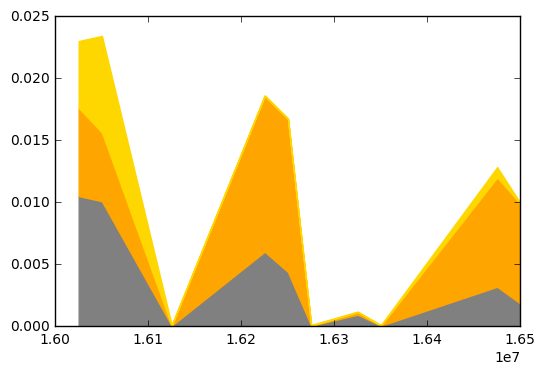

In [14]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

### P-values

Empirical P values are obtained from a relatively small number of genome-wide permutations by pooling across all conisdered steps.

In [15]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

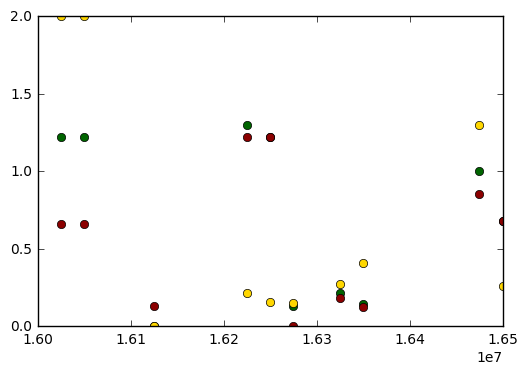

In [16]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

## Stratified design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts.
iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design).
We will here see application of iSet for analysis of stratified designs.

### Setting up

In [18]:
# activiate inline plotting
%matplotlib inline

from download_examples import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.iSet.iset import fit_iSet
import pandas as pd

In [19]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [20]:
# base name for bed, bim and fam
bfile = './data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [21]:
from limix.mtSet.core import plink_reader

In [22]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [23]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method `splitGeno` allows to define the regions that will then considered for the analysis with iSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| __method__      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| __size__      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| __minSnps__      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| __maxSnps__      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| __cache__       | False | bool | If true, it activates the caching |
| __out\_dir__     | './cache' | str | outdir of the cache file |
| __fname__       | None | str | Name of the file |
| __rewrite__     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [24]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


### Apply

In [25]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:1]
R = sp.loadtxt(sample_relatedness_file)
print(Y.shape)

(274, 1)


In [26]:
# let's suppose the first half of the individuals are phenotyped in context A and
# the second half on context B
Ie = sp.arange(R.shape[0])<0.5*R.shape[0]

In [27]:
# corrects for population structure using the first 10 PCs of the relatedness matrix
S_R, U_R = scipy.linalg.eigh(R+1e-4*sp.eye(R.shape[0])) # these are needed for the full mtSet model
F = sp.concatenate([U_R[:,-10:], sp.ones([U_R.shape[0], 1])], 1)

In [28]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [29]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time

for wnd_i in range(n_wnds):
    t0 = time.time()
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)

    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    xr = sp.dot(sp.rand(Xr.shape[0]), Xr)
    idxs_u = sp.sort(sp.unique(xr, return_index=True)[1])
    Xr = Xr[:,idxs_u]
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])

    _df, _df0 = fit_iSet(Y, F=F, Xr=Xr, Ie=Ie, n_nulls=10)
    df  = df.append(_df)
    df0 = df0.append(_df0)
    print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16025000-16075000) - 21 snps
Elapsed: 5.46386289597
.. window 1 - (22, 16050000-16100000) - 23 snps
Elapsed: 5.34179997444
.. window 2 - (22, 16125000-16175000) - 7 snps
Elapsed: 4.30499100685
.. window 3 - (22, 16225000-16275000) - 9 snps
Elapsed: 5.6210091114
.. window 4 - (22, 16250000-16300000) - 16 snps
Elapsed: 5.8319299221
.. window 5 - (22, 16275000-16325000) - 12 snps
Elapsed: 5.72252416611
.. window 6 - (22, 16325000-16375000) - 5 snps
Elapsed: 5.94124102592
.. window 7 - (22, 16350000-16400000) - 5 snps
Elapsed: 4.80616307259
.. window 8 - (22, 16475000-16525000) - 8 snps
Elapsed: 4.15918207169
.. window 9 - (22, 16500000-16550000) - 7 snps
Elapsed: 4.45016479492


The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence.

In [30]:
df

,Heterogeneity-GxC var,Persistent Var,Rescaling-GxC Var,iSet LLR,iSet-het LLR,mtSet LLR
0,-0.025807,0.059489,1.620445e-02,2.536120e-01,1.431980e-01,1.253018e+00
0,-0.017351,0.051698,8.162345e-03,1.151319e-01,9.235339e-02,1.046717e+00
0,-0.000100,0.000100,4.437414e-11,1.728208e-07,-4.211657e-09,-4.237307e-09
0,-0.017640,0.002922,3.255356e-02,5.018203e-01,1.145868e-08,5.018202e-01
0,-0.003076,0.001255,4.877466e-03,2.303760e-02,-1.327507e-09,2.301929e-02
0,-0.000100,0.000100,7.126069e-14,7.600009e-07,2.849561e-10,-2.643219e-12
0,-0.013473,0.013947,1.353159e-02,3.469951e-01,-2.905769e-04,3.541518e-01
0,-0.000100,0.000100,1.501852e-07,4.185099e-07,-6.807419e-07,-6.841037e-07
0,-0.001059,0.050339,7.098318e-04,1.430663e+00,5.423559e-01,2.143354e+00
0,-0.014258,0.025472,1.755192e-02,9.496528e-01,5.507864e-02,9.827788e-01


The dataframe df0 contains log likelihood ratios when data are from the null.
These are necessary to iSet to calculate P values.

In [31]:
df0

,iSet LLR0,iSet-het LLR0,mtSet LLR0
0,8.701465e-01,4.699373e-09,7.641269e-01
1,1.326539e+00,1.775959e-08,7.268617e-01
2,1.682668e-01,4.048806e-08,4.109243e-01
3,6.993162e-01,3.979626e-02,6.094640e-02
4,4.454416e-01,9.676313e-09,1.360218e+00
5,3.325469e-01,2.781690e-08,-2.262937e-10
6,3.882787e-03,3.794824e-08,-1.680718e-09
7,1.536725e+00,4.458499e-08,-1.468123e-09
8,4.738676e-02,1.543978e-08,-2.570744e-11
9,1.615154e+00,4.746059e-08,1.436369e+00


### Variance Component Plot

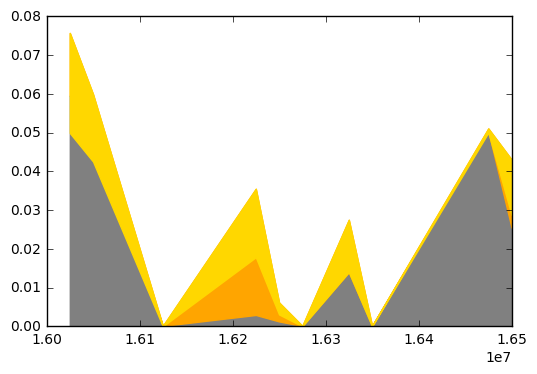

In [32]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

#### P-values

Empirical P values are obtained from a relatively small number of genome-wide permutations by pooling across all considered steps.

In [33]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

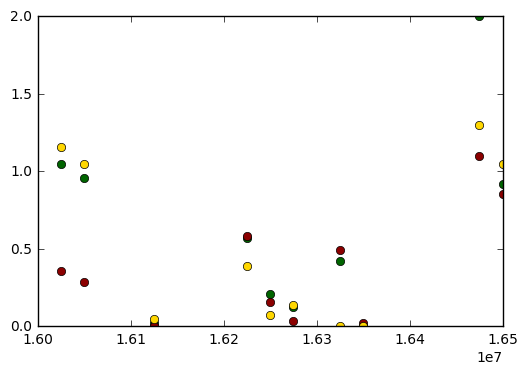

In [34]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

# Developers

- Francesco Paolo Casale (<casale@ebi.ac.uk>)
- Danilo Horta (<horta@ebi.ac.uk>)
- Barbara Rakitsch (<rakitsch@ebi.ac.uk>)
- Oliver Stegle (<stegle@ebi.ac.uk>)

# References

[1] Genomes Project, C. et al. An integrated map of genetic variation from 1,092 human genomes. Nature 491, 56-65 (2012).

<IPython.core.display.Javascript object>